In [285]:
print('Notes of lecture 3\nBuilding makemore Part 3: Activations & Gradients, BatchNorm')

Notes of lecture 3
Building makemore Part 3: Activations & Gradients, BatchNorm


In [286]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt  # for making figures
%matplotlib inline


In [287]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [288]:
len(words)

32033

In [289]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}

vocab_size = len(itos)

print(itos)
print(vocab_size)


{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [290]:
# build the dataset
block_size = 3  # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]  # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
import random

random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
# MLP revisited

n_embd = 10      # the dimensionality of the character embedding vectors
n_hidden = 200  # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C  = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**2) #0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

#batch norm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
# to calculate bngain, bnbias params in the back prop you have to do, "affine = True" in pytorch

print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True

12297


In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]                           # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1)  # concatenate the vectors
    hpreact = embcat @ W1 + b1            # hidden layer pre-activation 
    bnmeani = hpreact.mean(axis = 0, keepdim = True)
    bnstdi = hpreact.std(axis = 0, keepdim = True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias #batch norm layer
    with torch.no_grad(): #updating mean and standerd deviation without gradient descent 
        # the things that we are multiplying bnmeani and bnstdi are called momentum 
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)               # hidden layer
    logits = h @ W2 + b2                  # output layer
    loss = F.cross_entropy(logits, Yb)    # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01  # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:  # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.3147
  10000/ 200000: 2.1877
  20000/ 200000: 2.3251
  30000/ 200000: 2.4606
  40000/ 200000: 1.9243
  50000/ 200000: 2.4115
  60000/ 200000: 2.3451
  70000/ 200000: 2.0881
  80000/ 200000: 2.3196
  90000/ 200000: 2.1825
 100000/ 200000: 1.9393
 110000/ 200000: 2.2953
 120000/ 200000: 1.9052
 130000/ 200000: 2.3272
 140000/ 200000: 2.3035
 150000/ 200000: 2.2185
 160000/ 200000: 1.9161
 170000/ 200000: 1.7907
 180000/ 200000: 2.1811
 190000/ 200000: 1.8123


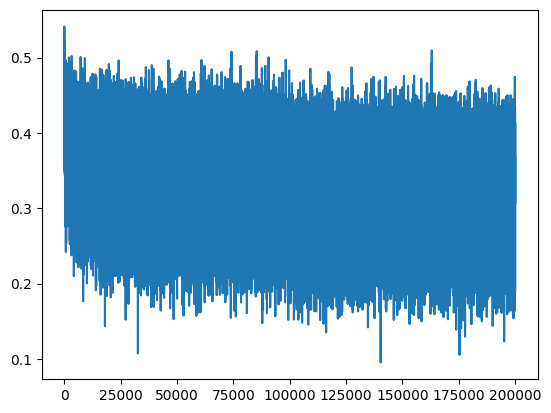

In [293]:
plt.plot(lossi)
#You can see that the plot of the loss dosent have a hockey shape appearance because the loss started small

In [299]:
@torch.no_grad()  # this decorator disables gradient tracking
def split_loss(split):
    X, y = {
        'train': (Xtr, Ytr),
        'val':   (Xdev, Ydev),
        'test':  (Xte, Yte),
    }[split]

    emb = C[X]                                   # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) 
    hpreact =  embcat @ W1 + b1       # concat into (N, block_size * n_embd)
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias 
    h = torch.tanh(hpreact)              # (N, n_hidden)
    logits = h @ W2 + b2                          # (N, vocab_size)
    loss = F.cross_entropy(logits, y)

    print(split, loss.item())


split_loss('train')
split_loss('val')

train 2.0598337650299072
val 2.1043901443481445


In [ ]:
import time
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size  # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])]        # (1, block_size, n_embd)
        hpreact = emb.view(1, -1) @ W1 + b1
        hpreact = bngain * ((hpreact - bnmean_running) / bnstd_running) + bnbias 
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        

        # if we sample the special '.' token, break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))  # decode and print the generated word

In [301]:
#pytorchifying the code

In [ ]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True

        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)                    # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True)      # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)     # normalize
        self.out = self.gamma * xhat + self.beta

        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    (1 - self.momentum) * self.running_mean + self.momentum * xmean
                )
                self.running_var = (
                    (1 - self.momentum) * self.running_var + self.momentum * xvar
                )

        return self.out
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


n_embd = 10        # the dimensionality of the character embedding vectors
n_hidden = 100     # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)  # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3


parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))  # number of parameters in total

for p in parameters:
    p.requires_grad = True


46497


In [303]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]  # batch X, Y

    # forward pass
    emb = C[Xb]                           # embed the characters into vectors
    x = emb.view(emb.shape[0], -1)        # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)         # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad()            # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01       # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0:                     # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    break  # AFTER_DEBUG: would take out obviously to run full optimization


      0/ 200000: 3.2962


layer 1 (      Tanh): mean -0.02, std 0.75, saturated: 20.25%
layer 3 (      Tanh): mean -0.00, std 0.69, saturated: 8.38%
layer 5 (      Tanh): mean +0.00, std 0.67, saturated: 6.62%
layer 7 (      Tanh): mean -0.01, std 0.66, saturated: 5.47%
layer 9 (      Tanh): mean -0.02, std 0.66, saturated: 6.12%


Text(0.5, 1.0, 'activation distribution')

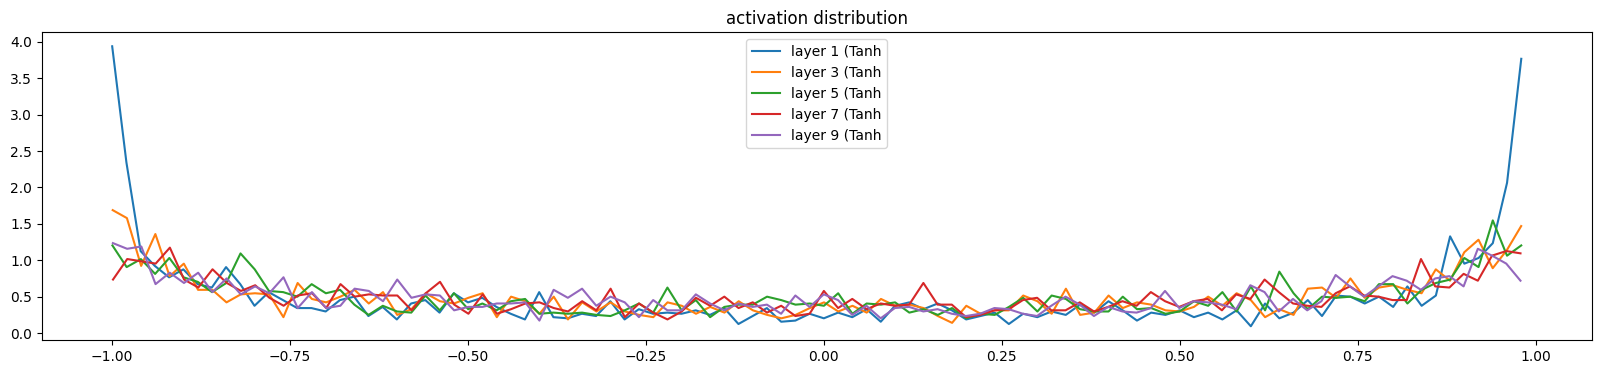

In [307]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}') 
plt.legend(legends);
plt.title('activation distribution')
#in this cell we are visualizing the histograms of forward activations, specifically at the tanh() layer
#and we are using the tanh layer because they have a finite optput -1 to 1
#we are calculating the mean stsnderd deviation and the percentage saturation of the tensor t 
#we are calculating the percantage saturation as any activation above 0.97 is marked as saturated
#so what we are looking at here is the of a how many values take on any of the values given. the more the height the more the number of activation
#the first layer is fairly saturated like 20% but then everything stabalizes when you go to the other layer
#the reason everyting stabalizes is because the gain is set 5/3
#if you dont use the gain (simply put it as one) you will see that the standerd starts to shrink layer after layer and the saturation goes to zero
#these tanh() layers are the squashing function so they take your distributin and they slightly squash it, so some gain is necessary to counter the squashing

layer 1 (      Tanh): mean +0.000010, std 4.205588e-04
layer 3 (      Tanh): mean -0.000003, std 3.991179e-04
layer 5 (      Tanh): mean +0.000003, std 3.743020e-04
layer 7 (      Tanh): mean +0.000015, std 3.290473e-04
layer 9 (      Tanh): mean -0.000014, std 3.054035e-04


Text(0.5, 1.0, 'gradient distribution')

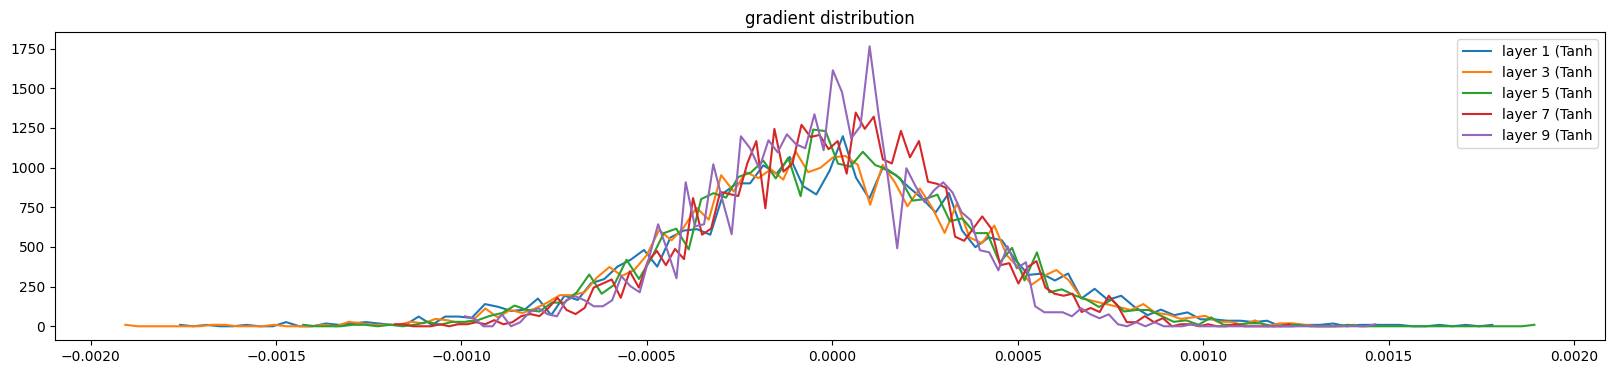

In [309]:
# visualize histograms of the gradients
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
#here we did the exact sane thing but insted of writing 
# t = layer.out; we are writing, t = layer.out.grad
# here we are also showing the mean and the standerd deviation and ploting the histogram of these values
#what we are looking for here is that all of the layers in the network have roughly the same gradient, things are not shrinking or explodinig

weight   (27, 10) | mean -0.000031 | std 1.365078e-03 | grad:data ratio 1.364090e-03
weight  (30, 100) | mean -0.000049 | std 1.207430e-03 | grad:data ratio 3.871660e-03
weight (100, 100) | mean +0.000016 | std 1.096730e-03 | grad:data ratio 6.601989e-03
weight (100, 100) | mean -0.000010 | std 9.893572e-04 | grad:data ratio 5.893091e-03
weight (100, 100) | mean -0.000011 | std 8.623432e-04 | grad:data ratio 5.158123e-03
weight (100, 100) | mean -0.000004 | std 7.388577e-04 | grad:data ratio 4.415212e-03
weight  (100, 27) | mean -0.000000 | std 2.364824e-02 | grad:data ratio 2.328203e+00


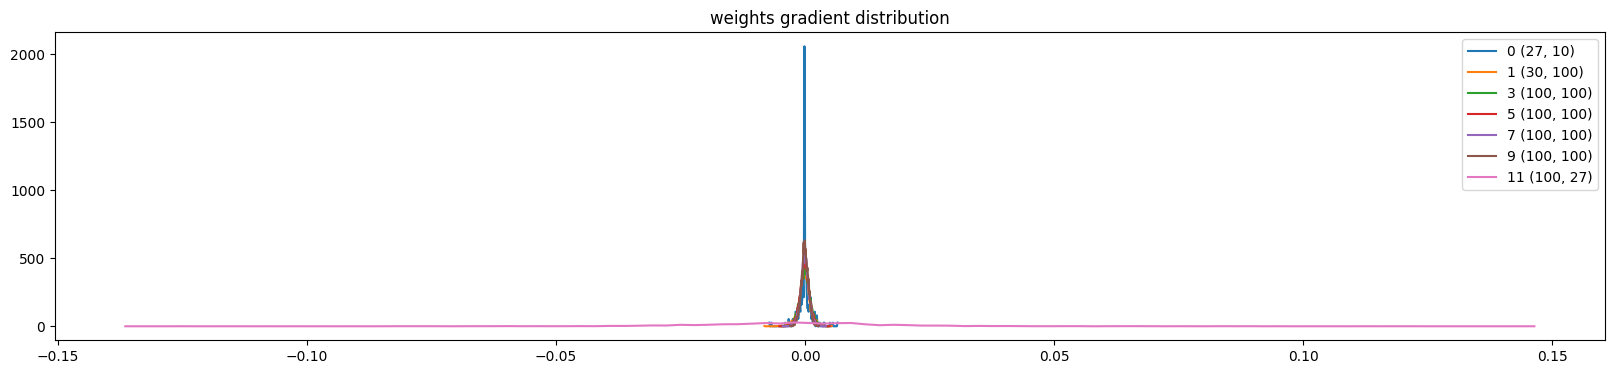

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');
#this here is the data and grad ratio
#we care about the parameters their values and their gradients, here we are iterating all the parameters and only restricting to the 2 dimensional parameters which are weights of the linear layer
#we are visualizing gradient to data ratio, it tells us the scale of the gradient compared to the scale of the actual values
#it is important because we are going to end up taking a step update that is the learning rate time gradients on to the data
#here the last layer is a bit of trouble maker in the way that its currently arranged
#here the last layer in pink takes on values much larger than some of the values inside the nn
#here the standerd deviations are roughly 1e-3 but in the last layer its like 2e-2 meaning the gradients on the last layer are 10 times greater than other grads inside the neural net
#this can be fixed if you let the optimization run for a longer time the grads in the last layer will become smaller and in the plot you will see that the pink lines will to start to shrink a little bit